In [1]:
import sys
sys.path.append("../src/data") 

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from feature_builder import FeatureBuilder
from sklearn.model_selection import GridSearchCV, GroupKFold
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [3]:
def combinations(num_min, num_max, num_step, len_min, len_max, len_step):
    numbers = range(num_min, num_max + 1, num_step)
    combos = []
    
    for size in range(len_min, len_max + 1, len_step):
        combos.extend(itertools.combinations_with_replacement(numbers, size))
    
    return combos

In [3]:
# Split the data into training, validation, and test sets if not already done
from generate_data_splits import generate_splits
generate_splits()

(1149, 246, 249)

In [5]:
train_data = FeatureBuilder(file_path="../data/raw_splits/train_data.csv", normalize=False, exclude_columns=[]).build_features()
val_data = FeatureBuilder(file_path="../data/raw_splits/val_data.csv", normalize=False, exclude_columns=[]).build_features()
test_data = FeatureBuilder(file_path="../data/raw_splits/test_data.csv", normalize=False, exclude_columns=[]).build_features()

y_train = train_data['label']
X_train = train_data.drop(columns=['id', 'label'])
y_val = val_data['label']
X_val = val_data.drop(columns=['id', 'label'])
y_test = test_data['label']
X_test = test_data.drop(columns=['id', 'label'])

d:\Personal Projects\311-ML-Food-Prediction\src\data\feature_builder.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df = self.df.applymap(lambda x: x.lower())
d:\Personal Projects\311-ML-Food-Prediction\src\data\feature_builder.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df = self.df.applymap(lambda x: x.lower())
d:\Personal Projects\311-ML-Food-Prediction\src\data\feature_builder.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df = self.df.applymap(lambda x: x.lower())


In [6]:
group_kfold = GroupKFold(n_splits=5)

X_train_final = pd.concat([X_train, X_val])
y_train_final = pd.concat([y_train, y_val])
groups_final = pd.concat([train_data["id"], val_data["id"]])

In [7]:
mlp = MLPClassifier(activation='relu', solver='sgd', random_state=42)

In [8]:
param_grid = {
    'hidden_layer_sizes': combinations(1, 302, 10, 1, 1, 1),
    'max_iter': [200]
}
grid_search = GridSearchCV(mlp, param_grid, cv=group_kfold, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train_final, y_train_final, groups=groups_final)

Fitting 5 folds for each of 31 candidates, totalling 155 fits


GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=MLPClassifier(random_state=42, solver='sgd'), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(1,), (11,), (21,), (31,),
                                                (41,), (51,), (61,), (71,),
                                                (81,), (91,), (101,), (111,),
                                                (121,), (131,), (141,), (151,),
                                                (161,), (171,), (181,), (191,),
                                                (201,), (211,), (221,), (231,),
                                                (241,), (251,), (261,), (271,),
                                                (281,), (291,), ...],
                         'max_iter': [200]},
             scoring='accuracy', verbose=1)

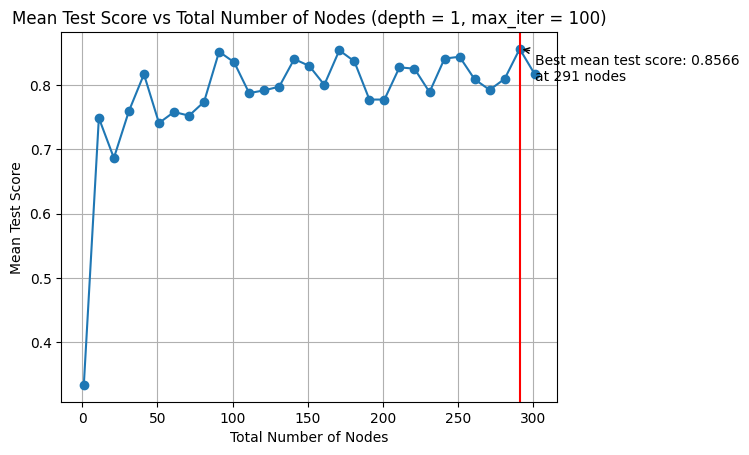

In [9]:
df = pd.DataFrame(grid_search.cv_results_)

#plt.figure(figsize=(15, 15))
plt.plot(df['param_hidden_layer_sizes'].apply(np.sum), df['mean_test_score'], linestyle='-', marker='o')

best_row = df.loc[df['mean_test_score'].idxmax()]
best_num_nodes = np.sum(best_row['param_hidden_layer_sizes'])
best_score = best_row['mean_test_score']

plt.axvline(best_num_nodes, color='r')
plt.annotate(f'Best mean test score: {best_score:.4f}\nat {best_num_nodes} nodes', 
             xy=(best_num_nodes, best_score), 
             xytext=(best_num_nodes + 10, best_score - 0.05),
             arrowprops=dict(arrowstyle='->', color='black'))
plt.xlabel("Total Number of Nodes")
plt.ylabel("Mean Test Score")
plt.title("Mean Test Score vs Total Number of Nodes (depth = 1, max_iter = 100)")

plt.grid(True)
plt.show()

In [10]:
param_grid = {
    'hidden_layer_sizes': [(91,)],
    'max_iter': range(50, 1001, 50)
}
grid_search = GridSearchCV(mlp, param_grid, cv=group_kfold, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train_final, y_train_final, groups=groups_final)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=MLPClassifier(random_state=42, solver='sgd'), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(91,)],
                         'max_iter': range(50, 1001, 50)},
             scoring='accuracy', verbose=1)

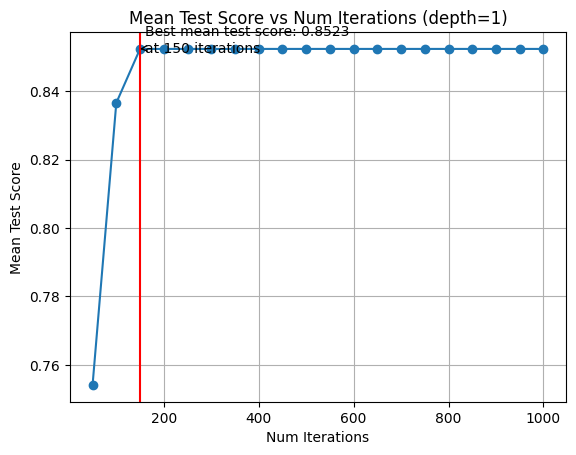

In [11]:
df = pd.DataFrame(grid_search.cv_results_)

#plt.figure(figsize=(15, 15))
plt.plot(df['param_max_iter'], df['mean_test_score'], linestyle='-', marker='o')

best_row = df.loc[df['mean_test_score'].idxmax()]
best_iter = best_row['param_max_iter']
best_score = best_row['mean_test_score']

plt.axvline(best_iter, color='r')

plt.annotate(f'Best mean test score: {best_score:.4f}\nat {best_iter} iterations', 
             xy=(best_iter, best_score), 
             xytext=(best_iter + 10, best_score - 0.001),
             arrowprops=dict(arrowstyle='->', color='black'))

plt.xlabel("Num Iterations")
plt.ylabel("Mean Test Score")
plt.title("Mean Test Score vs Num Iterations (depth=1)")


plt.grid(True)
plt.show()

In [12]:
combos = combinations(1, 100, 10, 2, 2, 1)
combos_desc = [combo for combo in combos if combo[0] >= combo[1]]
combos_asc = [combo for combo in combos if combo[0] < combo[1]]

param_grid = {
    'hidden_layer_sizes': combos_desc,
    'max_iter': [450]
}
grid_search_desc = GridSearchCV(mlp, param_grid, cv=group_kfold, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search_desc.fit(X_train_final, y_train_final, groups=groups_final)

param_grid = {
    'hidden_layer_sizes': combos_asc,
    'max_iter': [450]
}
grid_search_asc = GridSearchCV(mlp, param_grid, cv=group_kfold, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search_asc.fit(X_train_final, y_train_final, groups=groups_final)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=MLPClassifier(random_state=42, solver='sgd'), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(1, 11), (1, 21), (1, 31),
                                                (1, 41), (1, 51), (1, 61),
                                                (1, 71), (1, 81), (1, 91),
                                                (11, 21), (11, 31), (11, 41),
                                                (11, 51), (11, 61), (11, 71),
                                                (11, 81), (11, 91), (21, 31),
                                                (21, 41), (21, 51), (21, 61),
                                                (21, 71), (21, 81), (21, 91),
                                                (31, 41), (31, 51), (31, 61),
                                                (31, 71), (31, 81), (31, 91), ...],
                         'max_iter': [450]},
             scoring='accuracy', verbose=1)

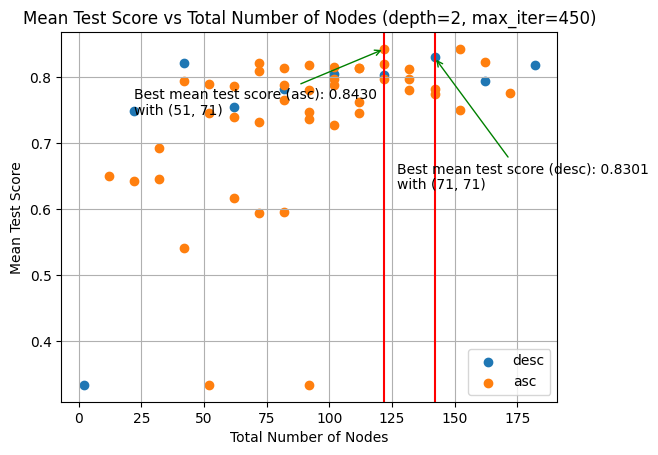

In [13]:
df_desc = pd.DataFrame(grid_search_desc.cv_results_)
df_asc = pd.DataFrame(grid_search_asc.cv_results_)

#plt.figure(figsize=(15, 15))
plt.scatter(df_desc['param_hidden_layer_sizes'].apply(np.sum), df_desc['mean_test_score'], linestyle='-', marker='o', label='desc')
plt.scatter(df_asc['param_hidden_layer_sizes'].apply(np.sum), df_asc['mean_test_score'], linestyle='-', marker='o', label='asc')

best_row_desc = df_desc.loc[df_desc['mean_test_score'].idxmax()]
best_nodes_desc = best_row_desc['param_hidden_layer_sizes']
best_num_nodes_desc = np.sum(best_nodes_desc)
best_score_desc = best_row_desc['mean_test_score']

plt.axvline(best_num_nodes_desc, color='r')
plt.annotate(f'Best mean test score (desc): {best_score_desc:.4f}\nwith {best_nodes_desc}', 
             xy=(best_num_nodes_desc, best_score_desc), 
             xytext=(best_num_nodes_desc - 15, best_score_desc - 0.2),
             arrowprops=dict(arrowstyle='->', color='green'))

best_row_asc = df_asc.loc[df_asc['mean_test_score'].idxmax()]
best_nodes_asc = best_row_asc['param_hidden_layer_sizes']
best_num_nodes_asc = np.sum(best_nodes_asc)
best_score_asc = best_row_asc['mean_test_score']

plt.axvline(best_num_nodes_asc, color='r')
plt.annotate(f'Best mean test score (asc): {best_score_asc:.4f}\nwith {best_nodes_asc}', 
             xy=(best_num_nodes_asc, best_score_asc), 
             xytext=(best_num_nodes_asc - 100, best_score_asc - 0.1),
             arrowprops=dict(arrowstyle='->', color='green'))

plt.xlabel("Total Number of Nodes")
plt.ylabel("Mean Test Score")
plt.title("Mean Test Score vs Total Number of Nodes (depth=2, max_iter=450)")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
combos = combinations(1, 121, 20, 3, 3, 1)

param_grid = {
    'hidden_layer_sizes': combos,
    'max_iter': [450]
}
grid_search = GridSearchCV(mlp, param_grid, cv=group_kfold, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train_final, y_train_final, groups=groups_final)


Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=MLPClassifier(random_state=42, solver='sgd'), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(1, 1, 1), (1, 1, 21),
                                                (1, 1, 41), (1, 1, 61),
                                                (1, 1, 81), (1, 1, 101),
                                                (1, 1, 121), (1, 21, 21),
                                                (1, 21, 41), (1, 21, 61),
                                                (1, 21, 81), (1, 21, 101),
                                                (1, 21, 121), (1, 41, 41),
                                                (1, 41, 61), (1, 41, 81),
                                                (1, 41, 101), (1, 41, 121),
                                                (1, 61, 61), (1, 61, 81),
                                                (1, 61, 101), (1, 61, 121),
                                                (1, 81, 81), (1, 81, 101),
                                                (1, 81, 121), (1, 101, 101),
                                                (1, 101, 121), (1, 121, 121),
                                                (21, 21, 21), (21, 21, 41), ...],
                         'max_iter': [450]},
             scoring='accuracy', verbose=1)

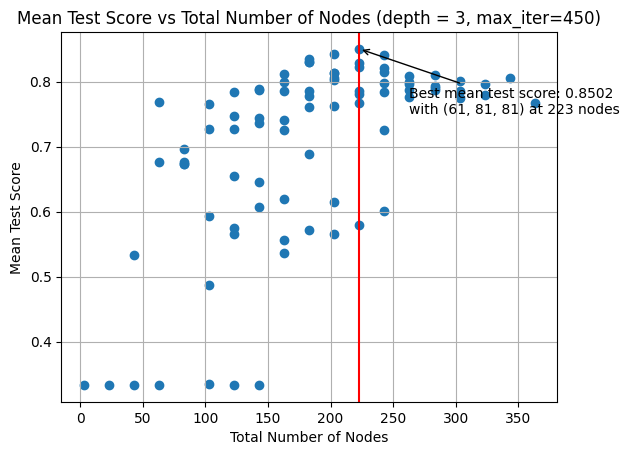

In [15]:
df = pd.DataFrame(grid_search.cv_results_)

#plt.figure(figsize=(15, 15))
plt.scatter(df['param_hidden_layer_sizes'].apply(np.sum), df['mean_test_score'], linestyle='-', marker='o')

best_row = df.loc[df['mean_test_score'].idxmax()]
best_nodes = best_row['param_hidden_layer_sizes']
best_num_nodes = np.sum(best_nodes)
best_score = best_row['mean_test_score']

plt.axvline(best_num_nodes, color='r')
plt.annotate(f'Best mean test score: {best_score:.4f}\nwith {best_nodes} at {best_num_nodes} nodes', 
             xy=(best_num_nodes, best_score), 
             xytext=(best_num_nodes +40, best_score - 0.1),
             arrowprops=dict(arrowstyle='->', color='black'))
plt.xlabel("Total Number of Nodes")
plt.ylabel("Mean Test Score")
plt.title("Mean Test Score vs Total Number of Nodes (depth = 3, max_iter=450)")

plt.grid(True)
plt.show()

In [16]:
combos = combinations(1, 51, 15, 4, 4, 1)

param_grid = {
    'hidden_layer_sizes': combos,
    'max_iter': [450]
}
grid_search = GridSearchCV(mlp, param_grid, cv=group_kfold, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train_final, y_train_final, groups=groups_final)


Fitting 5 folds for each of 35 candidates, totalling 175 fits


GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=MLPClassifier(random_state=42, solver='sgd'), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(1, 1, 1, 1), (1, 1, 1, 16),
                                                (1, 1, 1, 31), (1, 1, 1, 46),
                                                (1, 1, 16, 16), (1, 1, 16, 31),
                                                (1, 1, 16, 46), (1, 1, 31, 31),
                                                (1, 1, 31, 46), (1, 1, 46, 46),
                                                (1, 16, 16, 16),
                                                (1, 16, 16, 31),
                                                (1, 16, 16, 46),
                                                (1, 16, 31, 31),
                                                (1, 16, 31, 46),
                                                (1, 16, 46, 46),
                                                (1, 31, 31, 31),
                                                (1, 31, 31, 46),
                                                (1, 31, 46, 46),
                                                (1, 46, 46, 46),
                                                (16, 16, 16, 16),
                                                (16, 16, 16, 31),
                                                (16, 16, 16, 46),
                                                (16, 16, 31, 31),
                                                (16, 16, 31, 46),
                                                (16, 16, 46, 46),
                                                (16, 31, 31, 31),
                                                (16, 31, 31, 46),
                                                (16, 31, 46, 46),
                                                (16, 46, 46, 46), ...],
                         'max_iter': [450]},
             scoring='accuracy', verbose=1)

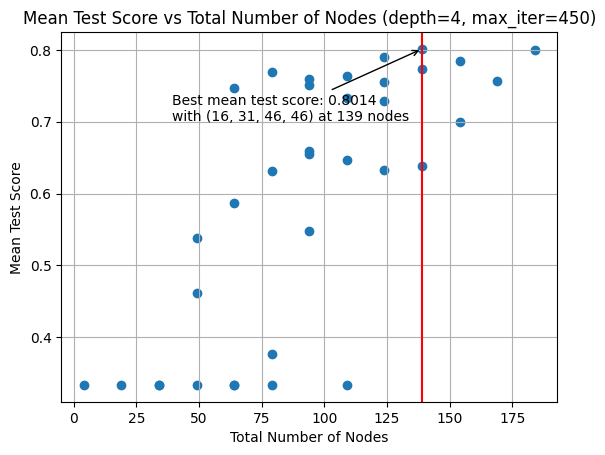

In [17]:
df = pd.DataFrame(grid_search.cv_results_)

#plt.figure(figsize=(15, 15))
plt.scatter(df['param_hidden_layer_sizes'].apply(np.sum), df['mean_test_score'], linestyle='-', marker='o')

best_row = df.loc[df['mean_test_score'].idxmax()]
best_nodes = best_row['param_hidden_layer_sizes']
best_num_nodes = np.sum(best_nodes)
best_score = best_row['mean_test_score']

plt.axvline(best_num_nodes, color='r')
plt.annotate(f'Best mean test score: {best_score:.4f}\nwith {best_nodes} at {best_num_nodes} nodes', 
             xy=(best_num_nodes, best_score), 
             xytext=(best_num_nodes -100, best_score - 0.1),
             arrowprops=dict(arrowstyle='->', color='black'))
plt.xlabel("Total Number of Nodes")
plt.ylabel("Mean Test Score")
plt.title("Mean Test Score vs Total Number of Nodes (depth=4, max_iter=450)")

plt.grid(True)
plt.show()

In [18]:
mlp = MLPClassifier(random_state=42)

combos = combinations(25, 100, 5, 2, 2, 1)

solvers = ['lbfgs', 'sgd', 'adam']

param_grid = {
    'hidden_layer_sizes': combos,
    'max_iter': [450],
    'solver': solvers
}
grid_search = GridSearchCV(mlp, param_grid, cv=group_kfold, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train_final, y_train_final, groups=groups_final)


Fitting 5 folds for each of 408 candidates, totalling 2040 fits


KeyboardInterrupt: 

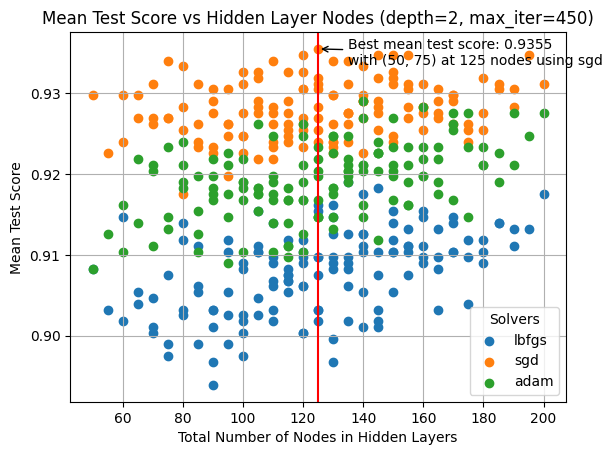

In [27]:
df = pd.DataFrame(grid_search.cv_results_)

#plt.figure(figsize=(15, 15))

for solver in solvers:
    df_solver = df[df['param_solver'] == solver]
    plt.scatter(df_solver['param_hidden_layer_sizes'].apply(np.sum),
                 df_solver['mean_test_score'], linestyle='-', marker='o', label=solver)

best_row = df.loc[df['mean_test_score'].idxmax()]
best_nodes = best_row['param_hidden_layer_sizes']
best_num_nodes = np.sum(best_nodes)
best_score = best_row['mean_test_score']
best_solver = best_row['param_solver']

plt.axvline(best_num_nodes, color='r')
plt.annotate(f'Best mean test score: {best_score:.4f}\nwith {best_nodes} at {best_num_nodes} nodes using {best_solver}', 
             xy=(best_num_nodes, best_score), 
             xytext=(best_num_nodes + 10, best_score - 0.002),
             arrowprops=dict(arrowstyle='->', color='black'))


plt.xlabel("Total Number of Nodes in Hidden Layers")
plt.ylabel("Mean Test Score")
plt.title("Mean Test Score vs Hidden Layer Nodes (depth=2, max_iter=450)")

plt.legend(title='Solvers')
plt.grid(True)
plt.show()

In [28]:
best_params = grid_search.best_params_

activations = ['identity', 'logistic', 'tanh', 'relu']

param_grid = {
    'hidden_layer_sizes': [best_params['hidden_layer_sizes']],
    'max_iter': [best_params['max_iter']],
    'solver': [best_params['solver']],
    'activation': activations
}
grid_search = GridSearchCV(mlp, param_grid, cv=group_kfold, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train_final, y_train_final, groups=groups_final)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\qumah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=GroupKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(50, 75)], 'max_iter': [450],
                         'solver': ['sgd']},
             scoring='accuracy', verbose=1)

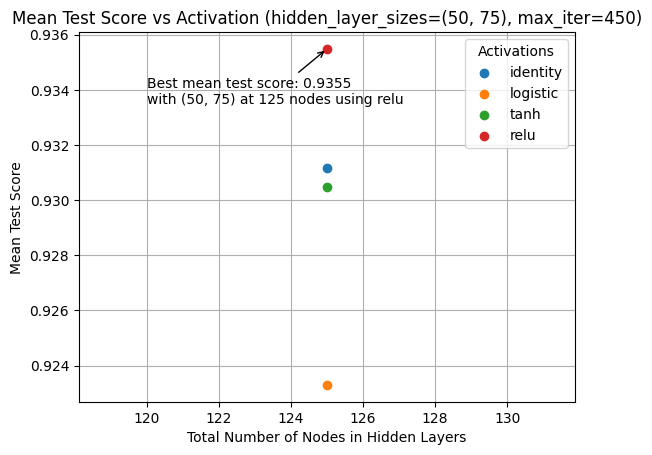

In [33]:
df = pd.DataFrame(grid_search.cv_results_)

#plt.figure(figsize=(10, 10))

for activation in activations:
    df_activation = df[df['param_activation'] == activation]
    plt.scatter(df_activation['param_hidden_layer_sizes'].apply(np.sum),
                 df_activation['mean_test_score'], linestyle='-', marker='o', label=activation)

best_row = df.loc[df['mean_test_score'].idxmax()]
best_nodes = best_row['param_hidden_layer_sizes']
best_num_nodes = np.sum(best_nodes)
best_score = best_row['mean_test_score']
best_activation = best_row['param_activation']

#plt.axvline(best_num_nodes, color='r')
plt.annotate(f'Best mean test score: {best_score:.4f}\nwith {best_nodes} at {best_num_nodes} nodes using {best_activation}', 
             xy=(best_num_nodes, best_score), 
             xytext=(best_num_nodes - 5, best_score - 0.002),
             arrowprops=dict(arrowstyle='->', color='black'))


plt.xlabel("Total Number of Nodes in Hidden Layers")
plt.ylabel("Mean Test Score")
plt.title(f"Mean Test Score vs Activation (hidden_layer_sizes={best_nodes}, max_iter=450)")

plt.legend(title='Activations')
plt.grid(True)
plt.show()

In [35]:
print("Best Parameters:", grid_search.best_params_)
print("Best Validation Accuracy:", grid_search.best_score_)

test_predictions = grid_search.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
print("Test Classification Report:\n", classification_report(y_test, test_predictions))

Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 75), 'max_iter': 450, 'solver': 'sgd'}
Best Validation Accuracy: 0.935483870967742
Test Accuracy: 0.9116465863453815
Test Classification Report:
               precision    recall  f1-score   support

       pizza       0.90      0.95      0.92        83
    shawarma       0.90      0.87      0.88        83
       sushi       0.94      0.92      0.93        83

    accuracy                           0.91       249
   macro avg       0.91      0.91      0.91       249
weighted avg       0.91      0.91      0.91       249



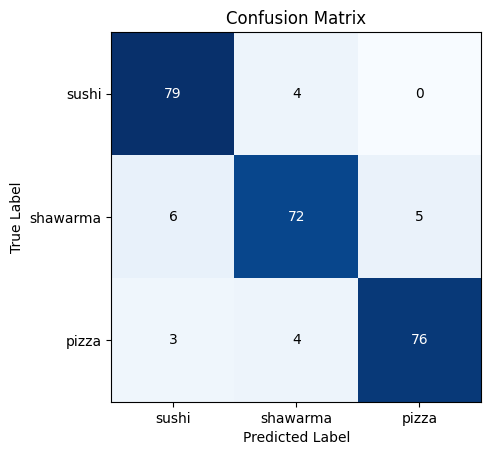

In [40]:
cm = confusion_matrix(y_test, test_predictions)
labels = list(set(y_test))  # Unique labels

# Plot confusion matrix
#plt.figure(figsize=(15, 15))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)

# Add labels to the axes
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Annotate each cell with the corresponding count
for i in range(len(labels)):
    for j in range(len(labels)):
        color = "white" if cm[i, j] > cm.max() / 2 else "black"  # Adjust contrast
        plt.text(j, i, cm[i, j], ha="center", va="center", color=color)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()